# Voltage Follower (Buffer) 

## Import and Formatting

The goal of this section is to import all the necessary files and libraries required for the subsequent data analysis.  
It also includes setting up the formatting parameters for the plots and visualizations.

### Import

In [1]:
# ============================================================
# Import Required Libraries
# ============================================================

# ------------------------------------------------------------
# Numerical and Plotting Libraries
# ------------------------------------------------------------
import numpy as np
import matplotlib.pyplot as plt

# ------------------------------------------------------------
# PySpice Core Classes
# ------------------------------------------------------------
from PySpice.Spice.Netlist import Circuit, SubCircuitFactory
from PySpice.Unit import *

# ============================================================
# End of Imports
# ============================================================

### Formatting

Adjusting Plotly chart settings for clarity and consistency.

In [2]:
# ----  Formatting charts
%matplotlib inline
from IPython.core.pylabtools import figsize
import matplotlib as mpl
mpl.rcParams['lines.linewidth'] = 2.0
mpl.rcParams['axes.edgecolor']  = "#bcbcbc"
mpl.rcParams['patch.linewidth'] = 0.5
mpl.rcParams['legend.fancybox'] = True
mpl.rcParams['axes.facecolor']  = "#eeeeee"
mpl.rcParams['axes.labelsize']  = "large"
mpl.rcParams['axes.grid']       = True
mpl.rcParams['grid.linestyle']  = "--"
mpl.rcParams['patch.edgecolor'] = "#eeeeee"
mpl.rcParams['axes.titlesize']  = "x-large"

## Circuit

The circuit of a **voltage follower amplifier** (also known as a **buffer** or **unity-gain amplifier**) is extremely simple.
As shown in the [](#Aopvoltagefollower), it consists of a single operational amplifier (op-amp) where:

* The **non-inverting input** (+) is connected directly to the input signal.
* The **inverting input** (−) is connected to the output of the op-amp, forming a **negative feedback loop**.

```{figure} ./images/Aopvoltagefollower.svg
:name: Aopvoltagefollower
:align: center
:width: 500px

Voltage follower circuit
```

## Equation

For an ideal op-amp configuration:

$$V_s = V_e$$

$$A_v = 1$$

$$Z_e = \infty$$

Thus, the **voltage gain** of this circuit is **unity (1)** — meaning the **output voltage is identical to the input voltage**.

At first glance, this might seem useless since there is no amplification in amplitude.
However, the **voltage follower** is one of the most **important configurations** in analog electronics and instrumentation.

Because the input impedance $Z_e$ is **very high** and the output impedance $Z_s$ is **very low**, this circuit acts as an **impedance isolator**.
In practice, this means:

* The **sensor** or **signal source** (often weak and sensitive) is not loaded or disturbed by the following stages.
* The **next circuit** (which might have low or variable impedance) can be connected without affecting the sensor signal.

In summary, the voltage follower provides a **clean electrical separation** between the source and the load, ensuring that the signal is transmitted **faithfully** without distortion or attenuation.

## Demonstration

```{figure} ./images/Aopvoltagefollower_demonstration.svg
:name: demonstation_aop_suiveur
:align: center
:width: 500px

Derivation of the voltage follower equation
```

From the [](#demonstation_aop_suiveur), we can write the following relations.
Assuming an ideal op-amp where $i^+ = i^- = 0$, and applying **Kirchhoff’s Voltage Law (KVL)**:

$$
V_s = \varepsilon + V_e
$$

However, for an ideal op-amp in equilibrium, the differential input voltage $\varepsilon = 0$.
Therefore, the final relationship becomes:

$$
\boxed{V_s = V_e}
$$

This confirms that the output **follows** the input perfectly.

## SPICE Circuit

The practical implementation of the follower in SPICE is shown in the [](#montage_aop_follower).

```{figure} ./images/Aopvoltagefollower_pyspace.svg
:name: montage_aop_follower
:align: center
:width: 500px

SPICE simulation schematic of a voltage follower
```

In this model, no additional active components are required — only:

* An **input resistor**, which can be varied to study the effect of input loading.
* An **output resistor**, used to observe how the system behaves under different load conditions.

```{important}
Don’t forget to include the **power supply voltages** for the op-amp in your simulation.
Without them, the circuit will not behave correctly.
```

In [3]:
# ------------------------------------------------------------
# Circuit Definition
# ------------------------------------------------------------
circuit = Circuit('Inverting Op-Amp Amplifier')

# Include uA741 operational amplifier model
circuit.include('lib/UA741.sub')

# ------------------------------------------------------------
# Power Supply
# ------------------------------------------------------------
circuit.V('cc', '+VCC', circuit.gnd, 15@u_V)
circuit.V('ee', '-VCC', circuit.gnd, -15@u_V)

# ------------------------------------------------------------
# Input Signal
# ------------------------------------------------------------
circuit.V('in', 'Vin', circuit.gnd, 1@u_V)

# ------------------------------------------------------------
# Operational Amplifier (uA741)
# Node order: non-inv, inv, +VCC, -VCC, output
# ------------------------------------------------------------
circuit.X(
    'U1', 
    'UA741',
    'Vin',      # Non-inverting input (+)
    'Vout',     # Inverting input (−)
    '+VCC', 
    '-VCC', 
    'Vout'      # Output
)

# ------------------------------------------------------------
# Resistive Network
# ------------------------------------------------------------
circuit.R('in', 'Vin', 'Vout', 380@u_Ohm)           # Input resistor
circuit.R('load', 'Vout', circuit.gnd, 380@u_Ohm);  # Load resistor

# ============================================================
# End of Circuit Definition
# ============================================================


.title Inverting Op-Amp Amplifier
.include C:\Users\sacha\Desktop\Python\Electronique\electronique_book\AOP\lib\UA741.sub
Vcc +VCC 0 15V
Vee -VCC 0 -15V
Vin Vin 0 1V
XU1 Vin Vout +VCC -VCC Vout UA741
Rin Vin Vout 380Ohm
Rload Vout 0 380Ohm



## Understanding Its Importance

At first glance, the analysis of this circuit seems straightforward — it leads to the same conclusions as the [inverting amplifier configuration](./02_Inverting_amplifier). Specifically, the circuit saturates when the output voltage approaches the supply limits $+V_{CC}$ or $-V_{EE}$.

It’s also important to note that the amplifier has a **finite bandwidth**. When the input signal frequency exceeds this bandwidth, the relationship between the input and output no longer holds as $V_s = V_e$; instead, the output amplitude decreases ($V_s < V_e$), and a **phase shift** appears between the two signals.

However, as we’ll see, regardless of where the signal is observed—whether at the input or the output—the voltage relationship remains effectively the same within the circuit’s operating range:

$$V_s = V_e$$

In [4]:
# ------------------------------------------------------------
# Simulation Setup
# ------------------------------------------------------------
simulator = circuit.simulator(temperature=25, nominal_temperature=25)

# ------------------------------------------------------------
# Operating Point Analysis
# ------------------------------------------------------------
analysis = simulator.operating_point()

# ------------------------------------------------------------
# Retrieve Simulation Results
# ------------------------------------------------------------
vin = analysis['vin']
vout = analysis['Vout']

# ------------------------------------------------------------
# Display Results
# ------------------------------------------------------------
print("------------------------------------------------------------")
print("Operating Point Results - Voltage Follower Configuration")
print("------------------------------------------------------------")
print(f"Input Voltage  (Vin)  : {vin[0]} V")
print(f"Output Voltage (Vout) : {vout[0]} V")

# ------------------------------------------------------------
# Verification (Ideal Follower → Vout ≈ Vin)
# ------------------------------------------------------------
if abs(vin[0] - vout[0]) < 1e-3:
    print("Status : OK → Circuit behaves as an ideal voltage follower.")
else:
    print("Status : Warning → Output deviates from expected follower behavior.")

------------------------------------------------------------
Operating Point Results - Voltage Follower Configuration
------------------------------------------------------------
Input Voltage  (Vin)  : 1.0 V V
Output Voltage (Vout) : 0.9999842762277193 V V
Status : OK → Circuit behaves as an ideal voltage follower.


What makes this configuration particularly interesting is that the input signal remains almost completely unchanged, thanks to the very high input impedance of the operational amplifier.

If this input impedance were not sufficiently high, a voltage drop could occur at the sensor output.
This happens because sensors typically deliver very low currents, meaning they cannot drive significant loads.
When the amplifier’s input impedance is too low, it draws current from the sensor, causing the measured voltage to drop — since, in practice, a sensor cannot be modeled as a perfect voltage source.

The second important observation is that the output voltage is very close to 1 V.
This small deviation is primarily due to simulation inaccuracies.
However, in a real-world circuit, you would never obtain exactly 1 V either, since several non-ideal parameters—such as offset voltages, bias currents, and component tolerances—come into play.

### Example — Understanding the Physical Meaning

The objective here is to understand **why having an infinitely large input resistance** is crucial when connecting to a sensor, or more generally, to **any imperfect voltage source**.

A **non-ideal voltage source** can be modeled as shown in [](#source-tension):
it consists of a **perfect voltage source** in series with an **internal resistance**, followed by the **load** connected to that source.

Based on this model, we can determine the **maximum current** that can be supplied by a 1 V voltage source with a **series resistance of 50 Ω**.
From **Ohm’s law**, we have:


```{figure} ./images/generateur_non_parfait.svg
:name: source-tension
:align: center
:width: 500px

Equivalent assembly of a non-perfect voltage source
```


$$
I_{\text{max}} = \frac{V_{\text{max}}}{R_{\text{source}}}
$$

which gives a maximum current of **20 mA**.

To analyze the effect of the load, we can test different output resistances:

* $R_{\text{load}} = 50 \Omega$
* $R_{\text{load}} = 380 \Omega$
* $R_{\text{load}} = 1 M\Omega$

In [5]:
# ------------------------------------------------------------
# Sensor Model Simulation - Effect of Internal Resistance
# ------------------------------------------------------------

# List of internal resistance values (Ohms)
resistances: list = [50, 380, 1e6]

# Dictionary to store output voltages for each resistance
v_output: dict = dict()

# ------------------------------------------------------------
# Simulation Loop
# ------------------------------------------------------------
for resistance in resistances:
    # --------------------------------------------------------
    # Circuit Definition
    # --------------------------------------------------------
    circuit = Circuit('Sensor Model')

    # Ideal voltage source (e.g., sensor delivering 1 V)
    circuit.V('sensor', 'r_internal', circuit.gnd, 1@u_V)

    # Load (e.g., amplifier or ADC input)
    circuit.R('load', 'r_internal', 'n_sensor', 50@u_Ohm)

    # Internal resistance of the sensor (model parameter)
    circuit.R('internal', 'n_sensor', circuit.gnd, resistance@u_Ohm)

    # --------------------------------------------------------
    # Simulation Setup
    # --------------------------------------------------------
    simulator = circuit.simulator(temperature=25, nominal_temperature=25)

    # --------------------------------------------------------
    # Operating Point Analysis
    # --------------------------------------------------------
    analysis = simulator.operating_point()

    # Store the node voltage at the sensor output
    v_output[resistance] = float(analysis['n_sensor'][0])

# ------------------------------------------------------------
# Display Results
# ------------------------------------------------------------
print("------------------------------------------------------------")
print("Sensor Output Voltage vs Internal Resistance")
print("------------------------------------------------------------")
for r_value, v_value in v_output.items():
    print(f"R_internal = {r_value:.0f} Ω → V_output = {v_value:.3f} V")

# ============================================================
# End of Simulation
# ============================================================

------------------------------------------------------------
Sensor Output Voltage vs Internal Resistance
------------------------------------------------------------
R_internal = 50 Ω → V_output = 0.500 V
R_internal = 380 Ω → V_output = 0.884 V
R_internal = 1000000 Ω → V_output = 1.000 V


In [6]:
# ------------------------------------------------------------
# Display Simulation Results
# ------------------------------------------------------------
print("------------------------------------------------------------")
print("Sensor Output Voltage vs Internal Resistance")
print("------------------------------------------------------------")

for resistance, voltage in v_output.items():
    print(f"Internal Resistance: {resistance:.0f} Ω\tOutput Voltage: {voltage:.3f} V")

# ============================================================
# End of Results Display
# ============================================================

------------------------------------------------------------
Sensor Output Voltage vs Internal Resistance
------------------------------------------------------------
Internal Resistance: 50 Ω	Output Voltage: 0.500 V
Internal Resistance: 380 Ω	Output Voltage: 0.884 V
Internal Resistance: 1000000 Ω	Output Voltage: 1.000 V


As previously explained, the **higher the load resistance**, the closer the **output voltage** is to the input voltage.
To approximate the output voltage, we can use the **voltage divider formula**:

$$
V_\text{out} = V_\text{in} \cdot \frac{R_\text{load}}{R_\text{load} + R_\text{internal}}
$$

Using this formula, we can calculate the output voltage for different load resistances:

$V_{50 \Omega} = 1 \cdot \frac{50}{50 + 50} = 0.5 \text{V}$

$V_{380 \Omega} = 1 \cdot \frac{380}{380 + 50} \approx 0.88 \text{V}$

$V_{1 \text{M}\Omega} = 1 \cdot \frac{1 000 000}{1 000 000 + 50} \approx 1.0 \text{V}$

**Conclusion:** The **larger the load resistance**, the **less the voltage drop**, which is why using a **high-input-impedance stage** after a sensor preserves the signal accurately.

## Limitations

As seen in the [*inverting Amplifier*](./02_Inverting_amplifier) section, the **output voltage is limited** by the power supply rails. At high frequencies, the amplifier’s behavior also changes due to **phase shift** and **amplitude loss**. The same limitations are observed in the **voltage follower** configuration.

### System Linearity

The system is limited by two main factors:

1. **Internal characteristics of the op-amp**, such as slew rate and bandwidth.
2. **Supply voltages applied to the op-amp terminals** (V_{CC}) and (V_{EE}).

In our example, the op-amp is powered with **+15 V and -15 V**, so we expect:

* A slope of **1**, representing the gain of the voltage follower.
* **Saturation** occurs when the output attempts to exceed the supply limits, i.e., slightly below +15 V and slightly above -15 V.

This behavior is illustrated in the [](#amplifier_linearity_suiveur)

```{figure} ./images/Linearity_and_saturation.svg
:name: amplifier_linearity_suiveur
:align: center
:width: 500px

Amplifier linearity and saturation
```

In [7]:
# ------------------------------------------------------------
# Circuit Definition
# ------------------------------------------------------------
circuit = Circuit('Inverting Op-Amp Amplifier')

# Include uA741 operational amplifier model
circuit.include('lib/UA741.sub')

# ------------------------------------------------------------
# Power Supply
# ------------------------------------------------------------
circuit.V('cc', '+VCC', circuit.gnd, 15@u_V)
circuit.V('ee', '-VCC', circuit.gnd, -15@u_V)

# ------------------------------------------------------------
# Input Signal
# ------------------------------------------------------------
circuit.V('in', 'Vin', circuit.gnd, 1@u_V)

# ------------------------------------------------------------
# Operational Amplifier (uA741)
# Node order: non-inv, inv, +VCC, -VCC, output
# ------------------------------------------------------------
circuit.X(
    'U1', 
    'UA741',
    'Vin',      # Non-inverting input (+)
    'Vout',     # Inverting input (−)
    '+VCC', 
    '-VCC', 
    'Vout'      # Output
)

# ------------------------------------------------------------
# Resistive Network
# ------------------------------------------------------------
circuit.R('in', 'Vin', 'Vout', 50@u_Ohm)           # Input resistor
circuit.R('load', 'Vout', circuit.gnd, 10@u_kOhm);  # Load resistor

# ============================================================
# End of Circuit Definition
# ============================================================

.title Inverting Op-Amp Amplifier
.include C:\Users\sacha\Desktop\Python\Electronique\electronique_book\AOP\lib\UA741.sub
Vcc +VCC 0 15V
Vee -VCC 0 -15V
Vin Vin 0 1V
XU1 Vin Vout +VCC -VCC Vout UA741
Rin Vin Vout 50Ohm
Rload Vout 0 10kOhm



In [8]:
# ------------------------------------------------------------
# DC Sweep Simulation
# ------------------------------------------------------------
simulator = circuit.simulator(temperature=25, nominal_temperature=25)

# Perform DC sweep of input voltage Vin from -17 V to 15 V in 0.01 V steps
analysis = simulator.dc(Vin=slice(-17, 15, 0.01))

# ------------------------------------------------------------
# Extract Simulation Data
# ------------------------------------------------------------
Vin_values = np.array(analysis.sweep)   # Array of input voltage values
Vout_values = np.array(analysis.Vout)   # Corresponding output voltage values

# ------------------------------------------------------------
# Optional: display first few points for verification
# ------------------------------------------------------------
print("DC Sweep Sample Results:")
for vin, vout in zip(Vin_values[::200], Vout_values[::200]):
    print(f"Vin = {vin:.2f} V → Vout = {vout:.2f} V")

# ============================================================
# End of DC Sweep Data Extraction
# ============================================================


DC Sweep Sample Results:
Vin = -17.00 V → Vout = -13.22 V
Vin = -15.00 V → Vout = -13.17 V
Vin = -13.00 V → Vout = -12.97 V
Vin = -11.00 V → Vout = -11.00 V
Vin = -9.00 V → Vout = -9.00 V
Vin = -7.00 V → Vout = -7.00 V
Vin = -5.00 V → Vout = -5.00 V
Vin = -3.00 V → Vout = -3.00 V
Vin = -1.00 V → Vout = -1.00 V
Vin = 1.00 V → Vout = 1.00 V
Vin = 3.00 V → Vout = 3.00 V
Vin = 5.00 V → Vout = 5.00 V
Vin = 7.00 V → Vout = 7.00 V
Vin = 9.00 V → Vout = 9.00 V
Vin = 11.00 V → Vout = 11.00 V
Vin = 13.00 V → Vout = 12.97 V
Vin = 15.00 V → Vout = 13.17 V


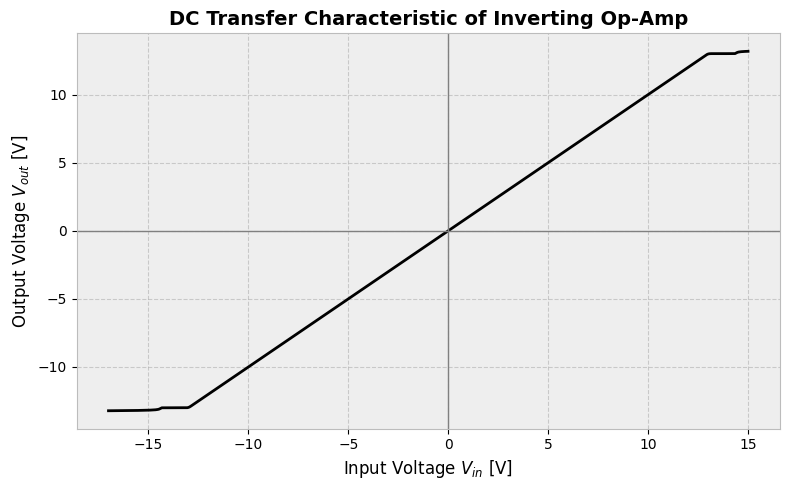

In [9]:
# ------------------------------------------------------------
# Plot DC Transfer Characteristic
# ------------------------------------------------------------
plt.figure(figsize=(8, 5))

# Plot Vin vs Vout
plt.plot(Vin_values, Vout_values, color='black', linewidth=2)

# ------------------------------------------------------------
# Graph Formatting
# ------------------------------------------------------------
plt.title('DC Transfer Characteristic of Inverting Op-Amp', fontsize=14, weight='bold')
plt.xlabel('Input Voltage $V_{in}$ [V]', fontsize=12)
plt.ylabel('Output Voltage $V_{out}$ [V]', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)

# Reference lines at 0 V
plt.axhline(0, color='gray', linewidth=1)
plt.axvline(0, color='gray', linewidth=1)

plt.tight_layout()
plt.show()

# ============================================================
# End of Plot
# ============================================================

It can be observed that the amplifier operates correctly within the range of **-10 V to +10 V**. However, as the output approaches the supply limits of **-15 V and +15 V**, the amplifier’s behavior changes. This issue seems to be a **simulation artifact**, possibly related to **numerical stability**, though the exact cause is not yet fully understood.

### Bode Diagram

The objective of this section is to generate the **Bode diagram** of the system.
This allows us to analyze both:

* The **bandwidth** of the amplifier
* The **phase shift** introduced by the system

By studying the Bode plot, we can better understand the **frequency response** and limitations of the voltage follower.

In [10]:
# ------------------------------------------------------------
# Circuit Definition
# ------------------------------------------------------------
circuit = Circuit('Inverting Op-Amp Amplifier')

# Include uA741 operational amplifier model
circuit.include('lib/UA741.sub')

# ------------------------------------------------------------
# Power Supply
# ------------------------------------------------------------
circuit.V('cc', '+VCC', circuit.gnd, 15@u_V)
circuit.V('ee', '-VCC', circuit.gnd, -15@u_V)

# ------------------------------------------------------------
# Input Signal
# ------------------------------------------------------------
circuit.SinusoidalVoltageSource('in', 'Vin', circuit.gnd, amplitude=9@u_V, frequency=1@u_Hz)

# ------------------------------------------------------------
# Operational Amplifier (uA741)
# Node order: non-inv, inv, +VCC, -VCC, output
# ------------------------------------------------------------
circuit.X(
    'U1', 
    'UA741',
    'Vin',      # Non-inverting input (+)
    'Vout',     # Inverting input (−)
    '+VCC', 
    '-VCC', 
    'Vout'      # Output
)

# ------------------------------------------------------------
# Resistive Network
# ------------------------------------------------------------
circuit.R('in', 'Vin', 'Vout', 50@u_Ohm)           # Input resistor
circuit.R('load', 'Vout', circuit.gnd, 10@u_kOhm);  # Load resistor

# ============================================================
# End of Circuit Definition
# ============================================================

.title Inverting Op-Amp Amplifier
.include C:\Users\sacha\Desktop\Python\Electronique\electronique_book\AOP\lib\UA741.sub
Vcc +VCC 0 15V
Vee -VCC 0 -15V
Vin Vin 0 DC 0V AC 1V SIN(0V 9V 1Hz 0s 0Hz)
XU1 Vin Vout +VCC -VCC Vout UA741
Rin Vin Vout 50Ohm
Rload Vout 0 10kOhm



In [11]:
# ------------------------------------------------------------
# AC Analysis Simulation
# ------------------------------------------------------------
simulator = circuit.simulator(temperature=25, nominal_temperature=25)

# Perform AC sweep from 10 Hz to 100 MHz with 1000 points per decade
analysis = simulator.ac(
    start_frequency=10@u_Hz,
    stop_frequency=100@u_MHz,
    number_of_points=1000,
    variation='dec'
)

# ------------------------------------------------------------
# Extract AC Analysis Data
# ------------------------------------------------------------
freq = np.array(analysis.frequency)                # Frequency array
Vout = np.array(analysis['Vout'])                 # Output voltage
Vin = np.array(analysis['vin'])                   # Input voltage

# Compute magnitude (gain) and phase difference
gain = np.abs(Vout) / np.abs(Vin)                 # Voltage gain |Vout/Vin|
phase = np.angle(Vout, deg=True) - np.angle(Vin, deg=True)  # Phase difference in degrees

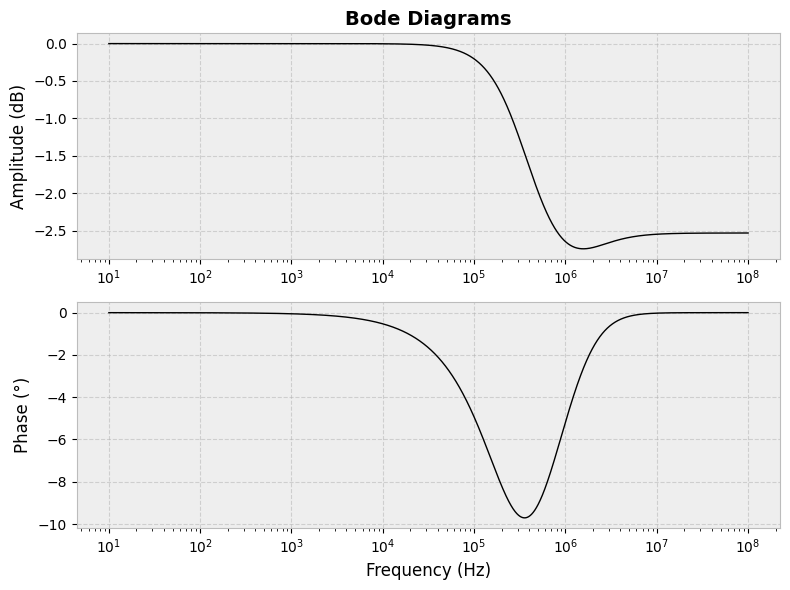

In [12]:
# ------------------------------------------------------------
# Bode Plot
# ------------------------------------------------------------
plt.figure(figsize=(8, 6))

# ------------------------------------------------------------
# Magnitude Plot (Top)
# ------------------------------------------------------------
plt.subplot(211)
plt.title('Bode Diagrams', fontsize=14, weight='bold')
plt.semilogx(freq, 20 * np.log10(gain), color='black', linewidth=1)  # Amplitude in dB
plt.ylabel('Amplitude (dB)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)

# ------------------------------------------------------------
# Phase Plot (Bottom)
# ------------------------------------------------------------
plt.subplot(212)
plt.semilogx(freq, phase, color='black', linewidth=1)  # Phase in degrees
plt.xlabel('Frequency (Hz)', fontsize=12)
plt.ylabel('Phase (°)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)

# ------------------------------------------------------------
# Adjust layout and show plot
# ------------------------------------------------------------
plt.tight_layout()
plt.show()

# ============================================================
# End of Bode Plot
# ============================================================

It can be observed that the **system is more stable** than when using a standard inverting amplifier, although the reason for this difference is not fully clear. Additionally, there appears to be a **phase shift** between **10 kHz and 10 MHz**. This could be problematic, as this frequency range is particularly relevant for studying mechanical sensors.

In terms of **amplitude**, the system performs well across almost the entire analyzed bandwidth, remaining above the **-3 dB threshold**. However, for this type of configuration, frequencies above **100 kHz** may raise questions about its practical use and reliability.